In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'CAD/JPY Exchange Rates'}, xlabel='Date'>

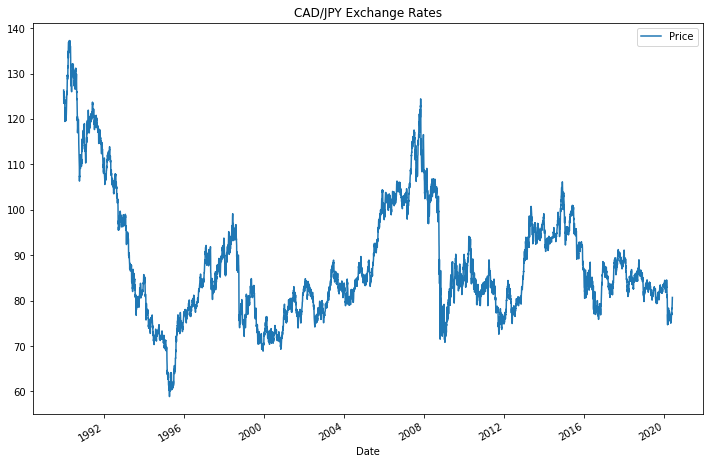

In [4]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df[["Price"]].plot(figsize=(12, 8), title="CAD/JPY Exchange Rates")

**Question:** Do you see any patterns, long-term and/or short? 

**Answer**:
Long-term strengthening of the Japanese Yen respective to the Canadian Dollar. There also seems to be a short term trend where a price drop is followed by a price increase but overall long-term trend of a downward trend of AUD against Yen.

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
noise, trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])

In [6]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
futures_decomp = cad_jpy_df[["Price"]].copy()
futures_decomp["noise"] = noise
futures_decomp["trend"] = trend
futures_decomp.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:title={'center':'Price vs. Trend'}, xlabel='Date'>

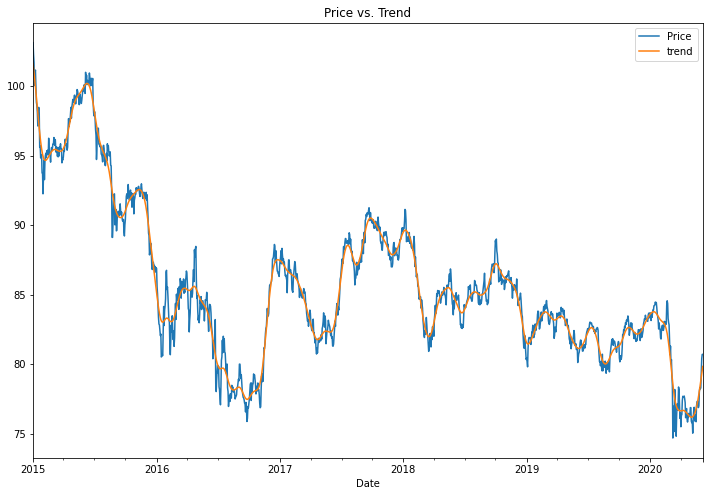

In [7]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
futures_decomp[["Price", "trend"]]["2015-01-01":].plot(figsize=(12, 8), title="Price vs. Trend")

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** short-term pattern where price revolves around the orange trend line, indicating potential but/sell opporunitites when price deviates away from trend 

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

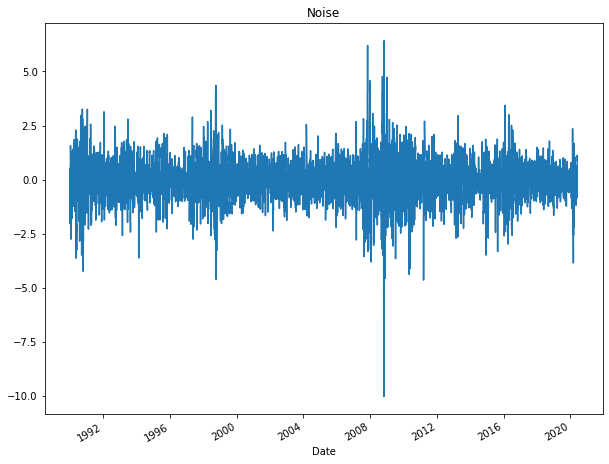

In [8]:
# Plot the Settle Noise
noise.plot(figsize=(10, 8), title="Noise")

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [10]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = sm.tsa.ARMA(returns, order=(2, 1))

# Fit the model and assign it to a variable called results
results = model.fit()

C:\Users\miche\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [11]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Price   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sat, 24 Jul 2021   AIC                          19513.955
Time:                        14:06:32   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.Price    -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.Price    -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.Price     0.8246      0.164      5.030      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1704           +0.0000j           42.1704            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

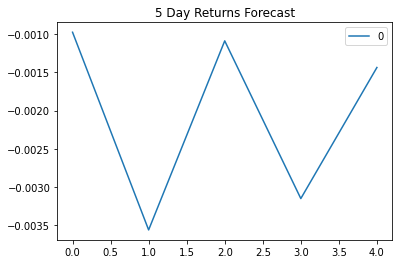

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** p-values>0.05, indicating a high probability of H0 Being wrongly rejected. current hypothesis is not so reliable and we might need to consider an alternative hypothesis. 

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate and ARIMA Model:
# Hint: ARIMA(df, order=(p, d, q))
model = ARIMA(cad_jpy_df[["Price"]], order=(5, 1, 1))

# Fit the model
results = model.fit()

C:\Users\miche\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\miche\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Sat, 24 Jul 2021   AIC                          17507.244
Time:                        14:06:35   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.856      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

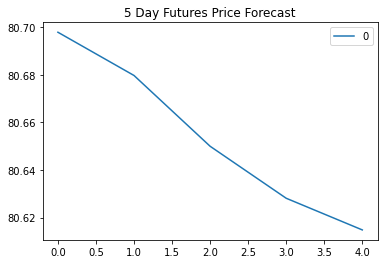

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:**CAD/JPY is expected to decrease, indicating a weaker CAD when compared to YEN in the next 5 days. i.e Yen is expected to apprecaite. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [16]:
import arch as arch

In [17]:
# Estimate a GARCH model:
model = arch.arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results = model.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 46548.40924082976
Iteration:      2,   Func. Count:     16,   Neg. LLF: 569545243.4284524
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8928.838552966728
Iteration:      4,   Func. Count:     27,   Neg. LLF: 11769.086094978014
Iteration:      5,   Func. Count:     33,   Neg. LLF: 10426.350185312931
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8916.366479560163
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8911.111921464748
Iteration:      8,   Func. Count:     52,   Neg. LLF: 8911.027336222945
Iteration:      9,   Func. Count:     57,   Neg. LLF: 8911.02203125968
Iteration:     10,   Func. Count:     62,   Neg. LLF: 8911.021014202204
Iteration:     11,   Func. Count:     67,   Neg. LLF: 8911.020776838068
Iteration:     12,   Func. Count:     72,   Neg. LLF: 8911.020764888566
Iteration:     13,   Func. Count:     76,   Neg. LLF: 8911.02076489123
Optimization terminated successfully    (Exit mode 0)
          

In [18]:
# Summarize the model results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Sat, Jul 24 2021   Df Residuals:                     7928
Time:                        14:06:39   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

**Note:** Our p-values for GARCH and volatility forecasts tend to be much lower than our ARMA/ARIMA return and price forecasts. In particular, here we have all p-values of less than 0.05, except for alpha(2), indicating overall a much better model performance. In practice, in financial markets, it's easier to forecast volatility than it is to forecast returns or prices. (After all, if we could very easily predict returns, we'd all be rich!)

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results.forecast(start=last_day, horizon=forecast_horizon)

In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566035,12.573725,12.581308,12.588786,12.596161


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566035
h.2,12.573725
h.3,12.581308
h.4,12.588786
h.5,12.596161


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

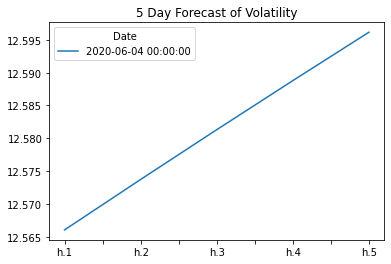

In [23]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** CAD/JPY volatility is expected to increase over the next 5 days. 

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?

   Yes. Our model indicated a potential YEN appreciation in the next 5 days.  

2. Is the risk of the yen expected to increase or decrease?
   
  Volatilicy is expected to increase over the next 5 days, indicating a higher risk. Higher returns normally comes with higher risk, so just a matter of whether risk is within the investor's tolerance level 

3. Based on the model evaluation, would you feel confident in using these models for trading?
  
  Our model is relatively good for forecast. Our ARMA model has a p-vlaue >0.05 which might need some more work. Our ARIMA model has a p-value>0.05, which might be more reliable. 